# IMPORTS

## Libraries

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import colors

## Data

In [13]:
from novelty_detection.data import load_data
data = load_data("banknote_authentication.txt", header_names=['x1', 'x2', 'x3', 'x4', 'y'])
print(data.shape)
data.head()

(1372, 5)


,x1,x2,x3,x4,y
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


# PREPROCESSING

In [14]:
X=data[['x1', 'x2', 'x3', 'x4']].to_numpy()
y=data[['y']].to_numpy()

## Split

In [15]:
# train and test split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
print('x train shape: ', train_x.shape)
print('y train shape: ', train_y.shape) 
print('x test shape: ', test_x.shape)
print('x test shape: ', test_y.shape)

x train shape:  (1097, 4)
y train shape:  (1097, 1)
x test shape:  (275, 4)
x test shape:  (275, 1)


## Scale

In [16]:
from novelty_detection.preprocessing import minmax_scaler
train_x_norm = minmax_scaler(train_x)
test_x_norm = minmax_scaler(test_x)
X_norm = minmax_scaler(X)

# DATA EXPLORATION

## Analysis classic

In [17]:
mean_values = np.mean(X, axis=0)
median_values = np.median(X, axis=0)
std_deviation = np.std(X, axis=0)
min_values = np.min(X, axis=0)
max_values = np.max(X, axis=0)
print("Mean: ", mean_values)
print("Median: ", median_values)
print("Standard deviation: ", std_deviation)


Mean:  [ 0.43373526  1.92235312  1.39762712 -1.19165652]
Median:  [ 0.49618  2.31965  0.61663 -0.58665]
Standard deviation:  [2.84172641 5.86690749 4.30845909 2.10024732]


In [18]:
# class distribution
class_labels, class_counts = np.unique(y, return_counts=True)

# correlation analysis
correlation_matrix = np.corrcoef(X, rowvar=False)

print('class labels:', class_labels)
print('class counts:', class_counts)
print('correlation matrix:\n', correlation_matrix)

class labels: [0 1]
class counts: [762 610]
correlation matrix:
 [[ 1.          0.26402553 -0.38084997  0.2768167 ]
 [ 0.26402553  1.         -0.78689522 -0.52632084]
 [-0.38084997 -0.78689522  1.          0.31884089]
 [ 0.2768167  -0.52632084  0.31884089  1.        ]]


## Analysis PCA

In [19]:
# 2D vizualization
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X_norm)

# Amount of explained variance kept 2D
exp_variance_2d = pca.explained_variance_ratio_
print(f"2D: Total = {np.sum(exp_variance_2d)} and per components = {exp_variance_2d}")

# 3D vizualization
pca = PCA(n_components = 3)
X3D = pca.fit_transform(X_norm)

# Amount of explained variance kept 3D
exp_variance_3d = pca.explained_variance_ratio_
print(f"3D: Total = {np.sum(exp_variance_3d)} and per components = {exp_variance_3d}")

2D: Total = 0.8722546870718808 and per components = [0.5539411  0.31831359]
3D: Total = 0.9550345564817728 and per components = [0.5539411  0.31831359 0.08277987]


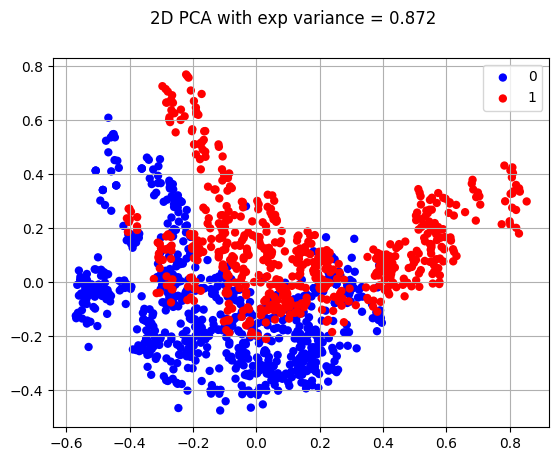

In [20]:
y_flat = y.ravel()

# Plot of the 2D PCA results
fig, ax = plt.subplots()

X2D_0 = X2D[y_flat == 0, :]
X2D_1 = X2D[y_flat == 1, :]

ax.scatter(X2D_0[:,0], X2D_0[:,1], color="blue", label="0", edgecolors='none')
ax.scatter(X2D_1[:,0], X2D_1[:,1], color="red", label="1", edgecolors='none')

ax.legend()
ax.grid(True)

fig.suptitle(f"2D PCA with exp variance = {round(np.sum(exp_variance_2d), 3)}")

plt.show()

# TRAINING

In [21]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("som_mini", "../scripts/som_implementations/som_moriwaki.py")
foo = importlib.util.module_from_spec(spec)
sys.modules["som_mini"] = foo
spec.loader.exec_module(foo)

model=foo.SOM_vectorized(som_grid_size=(10,10),
          max_cityblock=4,
          max_learning_rate=0.5,
          max_steps=10000,
          random_state=40)

model=model.fit(train_x_norm,train_y.ravel())

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
SOM training completed


c:\Users\edu12\Desktop\beca INIREC\repo\notebooks\../scripts/som_implementations/som_moriwaki.py:129: RuntimeWarning: invalid value encountered in divide
  label_map = ones_freq_map/occurence_freq_map


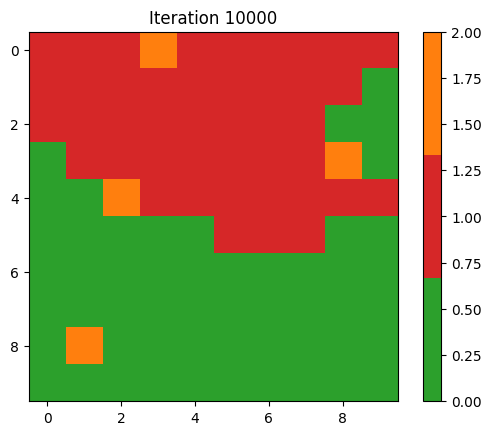

In [22]:
title = ('Iteration ' + str(model.max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(model.label_map_, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

# PREDICT

In [23]:
y_pred=model.predict(test_x_norm)

# SCORE

In [24]:
print(model.quantization_error(train_x_norm, model.som_))

0.07695572837838897


In [25]:
acc = accuracy_score(test_y, y_pred)
conf_matrix = confusion_matrix(test_y, y_pred)

print("Accuracy: ", acc)
print("Confusion Matrix: \n", conf_matrix)


Accuracy:  0.9490909090909091
Confusion Matrix: 
 [[145   2   1]
 [  9 116   2]
 [  0   0   0]]


In [26]:
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
cm_accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
avg_precision = average_precision_score(test_y, y_pred)

print('confusion matrix accuracy:',cm_accuracy)
print('precision:',precision)
print('recall:',recall)
print('F1:',f1_score)
print('avg precision:',avg_precision)

confusion matrix accuracy: 0.9595588235294118
precision: 0.9830508474576272
recall: 0.928
F1: 0.9547325102880659
avg precision: 0.9339658575735885
